<a href="https://colab.research.google.com/github/ArmandOvanessians/Disorder/blob/main/GNN_eXPLAINER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torch-geometric networkx
import os
disorder_folder_path = '/content/drive/My Drive/Disorder'
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import networkx as nx
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
import torch.nn.functional as F
import pickle
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GATConv, global_mean_pool
from google.colab import drive
import matplotlib.cm as cm
import torch
import torch.nn.functional as F

from torch_geometric.datasets import Planetoid
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.nn import GCNConv
import os
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.3 MB/s eta 0:00:00


In [2]:
# get graphs associated to the trained model that we are trying to explain on
graphs = drive.mount('/content/drive')
graphs_K = '/content/drive/My Drive/Disorder/Input_data/graphs_Kaia.pkl'

Mounted at /content/drive


In [3]:
labels = ['REP_Q2', 'REP_N2', 'REP_S2', 'REP_G2', 'REP_E2', 'REP_D2', 'REP_K2', 'REP_R2', 'REP_P2', 'REP_QN2',
'REP_RG2', 'REP_PR', 'REP_FG2', 'REP_SG2', 'REP_SR2', 'REP_KAP2', 'REP_PTS2', 'CLV_C14_Caspase3-7',
'DEG_APCC_KENBOX_2', 'DEG_Kelch_Keap1_1', 'DEG_SCF_TRCP1_1', 'DOC_ANK_TNKS_1', 'DOC_CYCLIN_RxL_1',
'DOC_MAPK_gen_1', 'DOC_MAPK_JIP1_4', 'DOC_MAPK_MEF2A_6', 'DOC_MAPK_NFAT4_5', 'DOC_PP1_RVXF_1',
'DOC_PP2A_B56_1', 'DOC_PP4_FxxP_1', 'DOC_WW_Pin1_4', 'LIG_14-3-3_CanoR_1', 'LIG_CaM_IQ_9',
'LIG_CtBP_PxDLS_1', 'LIG_EF_ALG2_ABM_1', 'LIG_EH_1', 'LIG_HCF-1_HBM_1', 'LIG_HOMEOBOX', 'LIG_KEPE_2',
'LIG_KLC1_WD_1', 'LIG_LIR_Gen_1', 'LIG_PAM2_1', 'LIG_PCNA_PIPBox_1', 'LIG_PDZ_Class_1',
'LIG_PDZ_Wminus1_1', 'LIG_PTAP_UEV_1', 'LIG_PTB_Apo_2', 'LIG_PTB_Phospho_1', 'LIG_Rb_LxCxE_1',
'LIG_SH2_CRK', 'LIG_SH2_GRB2like', 'LIG_SH2_NCK_1', 'LIG_SH2_SRC', 'LIG_SH2_STAP1', 'LIG_SH2_STAT5',
'LIG_SH3_2', 'LIG_SUMO_SIM_anti_2', 'LIG_SUMO_SIM_par_1', 'LIG_WRPW_1', 'MOD_CDK_SPK_2',
'MOD_CDK_SPxK_1', 'MOD_CDK_SPxxK_3', 'MOD_CK1_1', 'MOD_CK2_1', 'MOD_DYRK1A_RPxSP_1', 'MOD_GSK3_1',
'MOD_N-GLC_1', 'MOD_NMyristoyl', 'MOD_PIKK_1', 'MOD_PKA_1', 'MOD_PKA_2', 'MOD_PKB_1', 'MOD_Plk_1',
'MOD_ProDKin_1', 'MOD_SUMO_for_1', 'MOD_SUMO_rev_2', 'TRG_ER_diArg_1', 'TRG_ER_FFAT_1',
'TRG_LysEnd_APsAcLL_1', 'TRG_NES_CRM1_1', 'TRG_NLS_MonoExtN_4', 'A_homorep', 'C_homorep', 'D_homorep',
'E_homorep', 'G_homorep', 'H_homorep', 'I_homorep', 'K_homorep', 'L_homorep', 'M_homorep',
'N_homorep', 'P_homorep', 'Q_homorep', 'R_homorep', 'S_homorep', 'T_homorep', 'V_homorep',
'Y_homorep', 'FG_rich', 'PY', 'FRG', 'SGFYSG', 'PG_rich', 'ELASTIN_LIKE', 'FGxF', 'R_plus_Y',
'REP_RGG', 'AA_S', 'AA_P', 'AA_T', 'AA_A', 'AA_H', 'AA_Q', 'AA_N', 'AA_G', 'AA_R', 'AA_C', 'AA_D',
'AA_E', 'AA_F', 'AA_I', 'AA_K', 'AA_L', 'AA_M', 'AA_V', 'AA_W', 'AA_Y', 'acidic', 'basic',
'aliphatic', 'polar_fraction', 'chain_expanding', 'aromatic', 'disorder_promoting', 'net_charge',
'WF_complexity', 'KL_hydropathy', 'isoelectric_point', 'FCR', 'ED_ratio', 'RK_ratio', 'SCD']
print(len(labels))

143


In [4]:
# load graphs
with open(graphs_K, 'rb') as f:
  graphs_K = pickle.load(f)


In [5]:
# define model
class GATWithMasking(nn.Module):
    def __init__(self, num_features, hidden_dim, out_dim, num_classes=2, num_heads=4):
        super(GATWithMasking, self).__init__()

        # GATConv layers
        self.conv1 = GATConv(num_features, hidden_dim // num_heads, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_dim, out_dim, heads=1, concat=False)  # Output one attention head for the final layer

        # BatchNorm and Dropout
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # Add BatchNorm

        self.bn2 = nn.BatchNorm1d(out_dim)
        self.dropout = nn.Dropout(0.5)  # Add Dropout

        # Fully connected layer for classification output
        self.fc = nn.Linear(out_dim, num_classes)  # Output logits for num_classes

    def forward(self, x, edge_index):
        #x, edge_index, batch = data.x, data.edge_index, data.batch

        # Create a mask where 1 = valid, 0 = NaN (or missing)
        mask = ~torch.isnan(x)

        # Replace NaNs with 0 for computation
        x = torch.nan_to_num(x, nan=0.0)

        # Apply GATConv layers with batch normalization and dropout
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.bn2(self.conv2(x, edge_index))
        #x = global_mean_pool(x, batch)  # Pooling over the nodes in the same graph
        x = self.dropout(x)

        # Pass through final fully connected layer to output logits for each class
        logits = self.fc(x)
        return logits # Logits for each class

In [6]:
# Load model weights
model = GATWithMasking(num_features=graphs_K[0].x.shape[1], hidden_dim=32, out_dim=16)
# Load the state dictionary from the saved file
GAT_model_weights_path = '/content/drive/My Drive/Disorder/Models/TF_Isoforms/best_gat_model.pth'
model.load_state_dict(torch.load(GAT_model_weights_path))
# Set the model to evaluation mode for inference
model.eval()

<ipython-input-6-16fdb77e78df>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(GAT_model_weights_path))


GATWithMasking(
  (conv1): GATConv(143, 8, heads=4)
  (conv2): GATConv(32, 16, heads=1)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=16, out_features=2, bias=True)
)

In [7]:
# Initialize the Explainer
# Initialize the explainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',  # Set to 'classification' for your graph-level output
        task_level='graph',  # Still 'graph' since it's a graph-level prediction
        return_type='raw',  # Use logits for raw probabilities
    ),
)

In [101]:

# Testing on one graph
data = graphs_K[0]
x = data.x
edge_index = data.edge_index

explanation = explainer(x, edge_index)
node_mask = explanation.node_mask


Model Prediction: [1, 1]
Explainer Prediction (Masked): [1, 1]
The explainer's prediction matches the model's prediction.


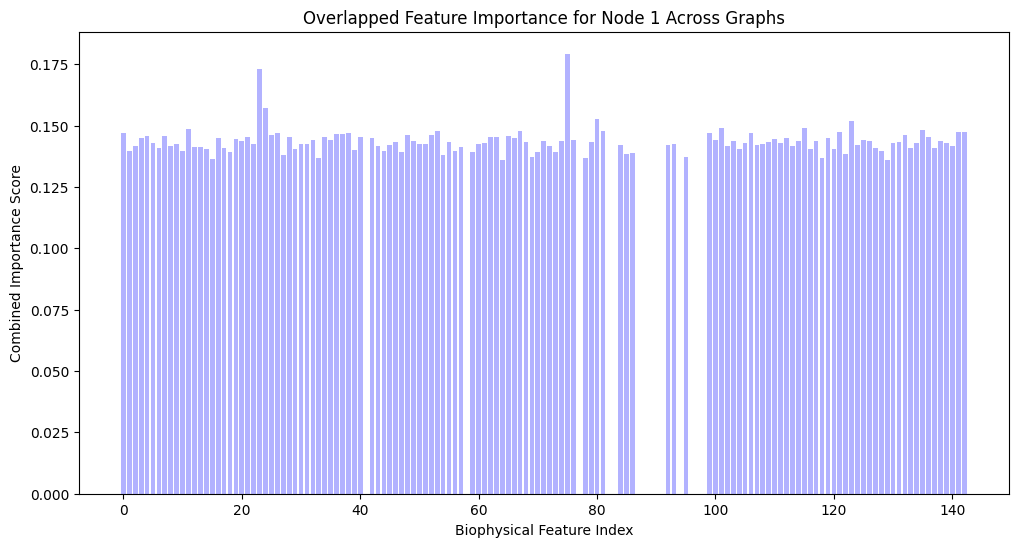

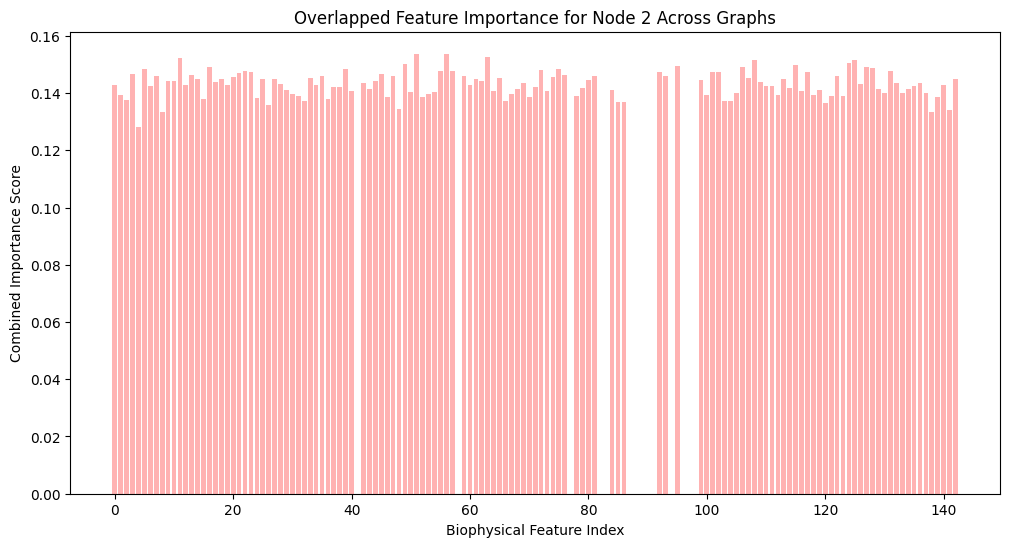

In [106]:
import matplotlib.pyplot as plt
import numpy as np

# Number of features in the node embeddings
num_features = graphs_K[0].x.size(1)

# Initialize arrays to accumulate feature importances
node1_importances = []
node2_importances = []

# Iterate through the first 10 graphs in graphs_K
for i, data in enumerate(graphs_K[:10]):
    x = data.x
    edge_index = data.edge_index

    # Generate explanation for the current graph
    explanation = explainer(x, edge_index)
    node_mask = explanation.node_mask

    # Store feature importances for node 1
    if x.size(0) > 0:
        node1_importances.append(node_mask[0].cpu().numpy())

    # Store feature importances for node 2 if present
    if x.size(0) > 1:
        node2_importances.append(node_mask[1].cpu().numpy())
    if x.size(0) > 1:
        node2_importances.append(node_mask[1].cpu().numpy())

# Convert lists to arrays and compute mean feature importances
node1_importances = np.array(node1_importances)
node2_importances = np.array(node2_importances)

# Compute average importance and occurrence frequency for node 1
mean_importance_node1 = np.mean(node1_importances, axis=0)
freq_node1 = np.sum(node1_importances > 0, axis=0) / len(node1_importances)

# Compute average importance and occurrence frequency for node 2
mean_importance_node2 = np.mean(node2_importances, axis=0)
freq_node2 = np.sum(node2_importances > 0, axis=0) / len(node2_importances)

# Plot overlapped feature importances for node 1
plt.figure(figsize=(12, 6))
plt.bar(range(num_features), mean_importance_node1 * freq_node1, alpha=0.3, color='b', label='Node 1')
plt.xlabel('Biophysical Feature Index')
plt.ylabel('Combined Importance Score')
plt.title('Overlapped Feature Importance for Node 1 Across Graphs')
plt.show()

# Plot overlapped feature importances for node 2
plt.figure(figsize=(12, 6))
plt.bar(range(num_features), mean_importance_node2 * freq_node2, alpha=0.3, color='r', label='Node 2')
plt.xlabel('Biophysical Feature Index')
plt.ylabel('Combined Importance Score')
plt.title('Overlapped Feature Importance for Node 2 Across Graphs')
plt.show()


In [8]:
activator_graphs = [graph for graph in graphs_K if graph.y == 1]  # Activators (label 1)
repressor_graphs = [graph for graph in graphs_K if graph.y == -1]  # Repressors (label 0)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of features in the node embeddings
num_features = graphs_K[0].x.size(1)

# Initialize lists to collect feature importances for each node across graphs
node1_importances = []
node2_importances = []
node3_importances = []
node4_importances = []
node5_importances = []

# Iterate through the repressor graphs
for i, data in enumerate(activator_graphs):
    x = data.x
    edge_index = data.edge_index

    # Generate explanation for the current graph
    explanation = explainer(x, edge_index)
    node_mask = explanation.node_mask

    # Store feature importances for each node, if present
    if x.size(0) > 0:
        node1_importances.append(node_mask[0].cpu().numpy())
    if x.size(0) > 1:
        node2_importances.append(node_mask[1].cpu().numpy())
    if x.size(0) > 2:
        node3_importances.append(node_mask[2].cpu().numpy())
    if x.size(0) > 3:
        node4_importances.append(node_mask[3].cpu().numpy())
    if x.size(0) > 4:
        node5_importances.append(node_mask[4].cpu().numpy())

# Function to plot overlapping feature importances
def plot_overlapping_importances(label, importances, node_num, color):
    plt.figure(figsize=(24, 6))
    for imp in importances:
        plt.bar(label, imp, alpha=0.1, color=color)
        plt.xticks(rotation=60, ha='right', fontsize=6)
    plt.xlabel('Biophysical Feature Index')
    plt.ylabel('Importance Score')
    plt.title(f'Overlapping Feature Importance for Node {node_num} Across Graphs')
    plt.show()

# Plot for each node (up to 5 nodes)
plot_overlapping_importances(labels, node1_importances, 1, 'b')  # Node 1 in blue
plot_overlapping_importances(labels, node2_importances, 2, 'r')  # Node 2 in red
plot_overlapping_importances(labels, node3_importances, 3, 'g')  # Node 3 in green
plot_overlapping_importances(labels, node4_importances, 4, 'orange')  # Node 4 in orange
plot_overlapping_importances(labels, node5_importances, 5, 'purple')  # Node 5 in purple


In [126]:
node1_importances_rep =
node2_importances_rep =
node3_importances_rep =
node4_importances_rep =
node5_importances_rep =

42

In [52]:
# applying to the whole datset
# Separate graphs into activators and repressors
activator_graphs = [graph for graph in graphs_K if graph.y == 1]  # Activators (label 1)
repressor_graphs = [graph for graph in graphs_K if graph.y == -1]  # Repressors (label 0)

# Initialize lists to store feature importances
activator_node_importances = []
repressor_node_importances = []
activator_edge_importances = []
repressor_edge_importances = []

# Process activator graphs
for i, graph in enumerate(activator_graphs):
    x = graph.x
    edge_index = graph.edge_index

    # Generate explanation for activator (class 1)
    explanation = explainer(x, edge_index)
    print(graph)

    # Store node and edge importances
    activator_node_importances.append(explanation.node_mask)
    activator_edge_importances.append(explanation.edge_mask)

# Process repressor graphs
for i, graph in enumerate(repressor_graphs):
    x = graph.x
    edge_index = graph.edge_index

    # Generate explanation for repressor (class 0)
    explanation = explainer(x, edge_index)
    print(graph)


    # Store node and edge importances
    repressor_node_importances.append(explanation.node_mask)
    repressor_edge_importances.append(explanation.edge_mask)

Data(x=[2, 143], edge_index=[2, 2], idr_id=[2], y=[1], clone_id='ARNT2-1')
Data(x=[2, 143], edge_index=[2, 2], idr_id=[2], y=[1], clone_id='ARNT2-2')
Data(x=[2, 143], edge_index=[2, 2], idr_id=[2], y=[1], clone_id='ATF2-2')
Data(x=[1, 143], edge_index=[2, 0], idr_id=[1], y=[1], clone_id='ATF2-5')
Data(x=[1, 143], edge_index=[2, 0], idr_id=[1], y=[1], clone_id='CREB1-1')
Data(x=[1, 143], edge_index=[2, 0], idr_id=[1], y=[1], clone_id='CREB1-2')
Data(x=[2, 143], edge_index=[2, 2], idr_id=[2], y=[1], clone_id='CREB5-1')
Data(x=[2, 143], edge_index=[2, 2], idr_id=[2], y=[1], clone_id='CREBZF-1')
Data(x=[1, 143], edge_index=[2, 0], idr_id=[1], y=[1], clone_id='CREM-1')
Data(x=[2, 143], edge_index=[2, 2], idr_id=[2], y=[1], clone_id='CTCF-1')
Data(x=[4, 143], edge_index=[2, 12], idr_id=[4], y=[1], clone_id='CXXC1-2')
Data(x=[1, 143], edge_index=[2, 0], idr_id=[1], y=[1], clone_id='DDIT3-1')
Data(x=[1, 143], edge_index=[2, 0], idr_id=[1], y=[1], clone_id='DLX1-2')
Data(x=[1, 143], edge_index=

Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Color: blue
Graph label: 1, Colo

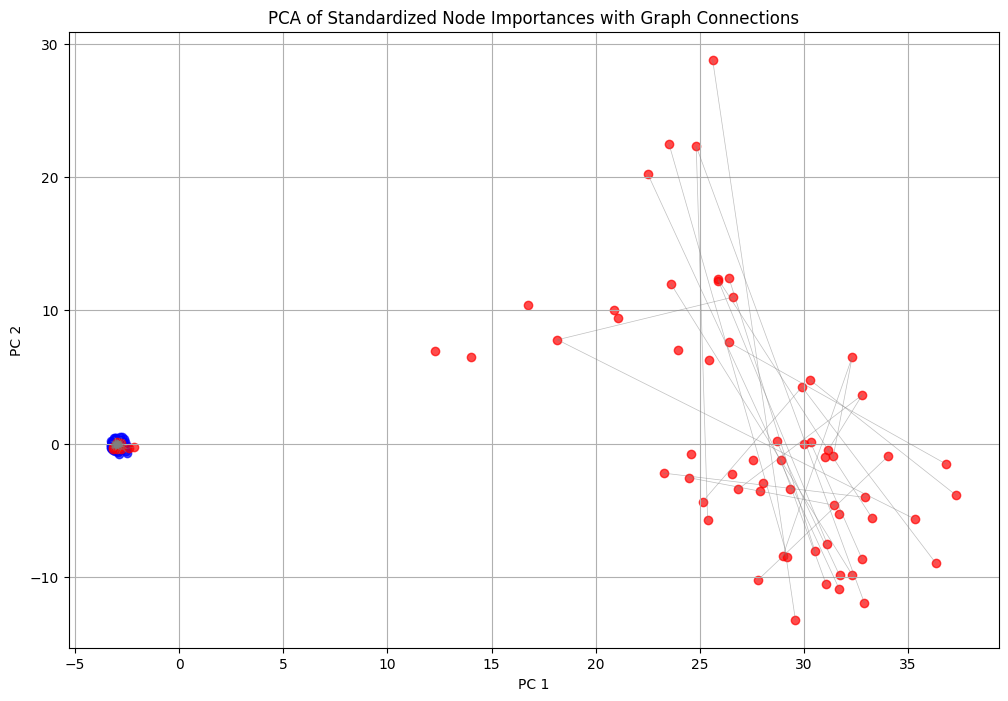

In [60]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# Combine node importance vectors across all graphs
all_node_importances = []
graph_labels = []  # Keeps track of whether it's from activator (1) or repressor (-1)
graph_indices = []  # Keeps track of which graph each node belongs to

# Process activator graphs
for i, node_importance in enumerate(activator_node_importances):
    all_node_importances.extend(node_importance.cpu().detach().numpy())
    graph_labels.extend([1] * node_importance.size(0))  # Label as activator (1)
    graph_indices.extend([i] * node_importance.size(0))  # Track graph index

# Process repressor graphs
for i, node_importance in enumerate(repressor_node_importances):
    all_node_importances.extend(node_importance.cpu().detach().numpy())
    graph_labels.extend([-1] * node_importance.size(0))  # Label as repressor (-1)
    graph_indices.extend([i + len(activator_node_importances)] * node_importance.size(0))  # Track graph index

# Convert to NumPy array
all_node_importances = np.array(all_node_importances)

# Standardize the node importance vectors
scaler = StandardScaler()
all_node_importances_standardized = scaler.fit_transform(all_node_importances)

# Apply PCA to the standardized node importance vectors
pca = PCA(n_components=2)
reduced_importances = pca.fit_transform(all_node_importances_standardized)

# Plotting
plt.figure(figsize=(12, 8))

# Color map for activators and repressors
color_map = {1: 'blue', -1: 'red'}

# Plot each node in reduced PCA space
for i in range(len(reduced_importances)):
    label = graph_labels[i]

    color = color_map[label]
    print(f"Graph label: {label}, Color: {color}")
    plt.scatter(reduced_importances[i, 0], reduced_importances[i, 1], c=color, alpha=0.7)

# Connect nodes within the same graph
for i in range(max(graph_indices) + 1):
    # Get indices of nodes belonging to the same graph
    indices = [j for j, graph_index in enumerate(graph_indices) if graph_index == i]
    if len(indices) > 1:  # Only connect if there are at least 2 nodes
        xs = reduced_importances[indices, 0]
        ys = reduced_importances[indices, 1]
        plt.plot(xs, ys, linestyle='-', linewidth=0.5, alpha=0.5, color='gray')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA of Standardized Node Importances with Graph Connections')
plt.grid(True)
plt.show()


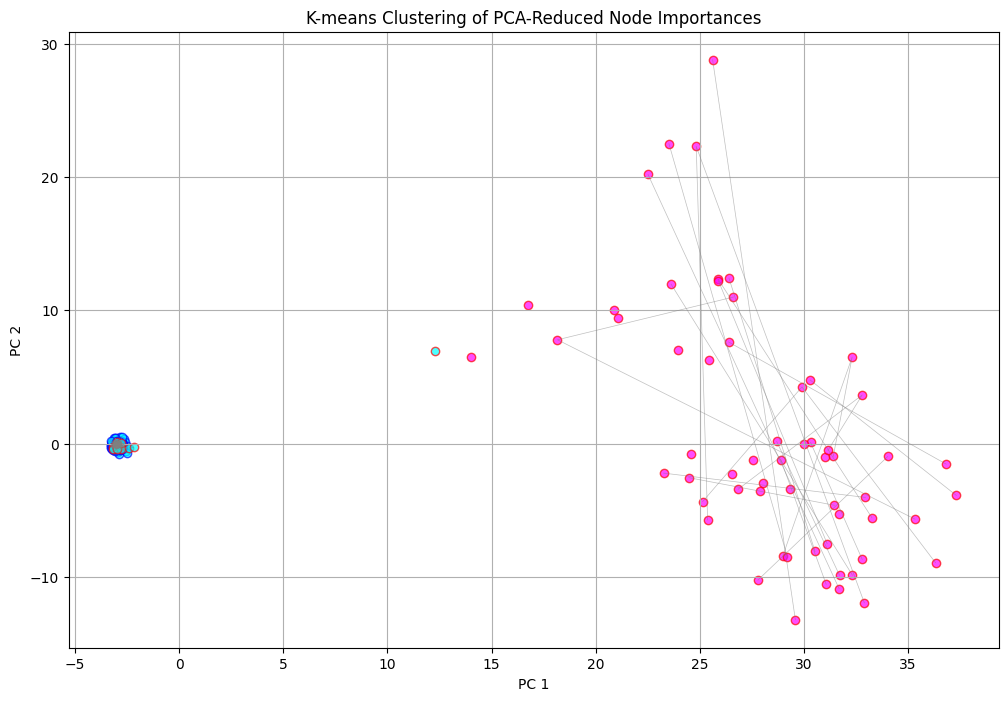

Repressors in activator-like cluster: 11
Activators in repressor-like cluster: 0


In [62]:
from sklearn.cluster import KMeans
import numpy as np

# Set the number of clusters (e.g., 2 clusters for activator-like and repressor-like)
num_clusters = 2

# Apply k-means clustering to the PCA-reduced node importances
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(reduced_importances)

# Plotting in 2D space
plt.figure(figsize=(12, 8))

# Color map for activators, repressors, and clusters
node_colors = {1: 'blue', -1: 'red'}
cluster_colors = ['cyan', 'magenta']  # Adjust for different clusters

# Plot each node in the 2D PCA space with cluster colors
for i, label in enumerate(cluster_labels):
    original_label = graph_labels[i]  # Original activator or repressor label
    color = cluster_colors[label]  # Color based on cluster
    edge_color = node_colors[original_label]  # Edge color based on activator or repressor
    plt.scatter(reduced_importances[i, 0], reduced_importances[i, 1],
                c=color, edgecolors=edge_color, alpha=0.7)

# Connect nodes within the same graph
for i in range(max(graph_indices) + 1):
    # Get indices of nodes belonging to the same graph
    indices = [j for j, graph_index in enumerate(graph_indices) if graph_index == i]
    if len(indices) > 1:  # Only connect if there are at least 2 nodes
        xs = reduced_importances[indices, 0]
        ys = reduced_importances[indices, 1]
        plt.plot(xs, ys, linestyle='-', linewidth=0.5, alpha=0.5, color='gray')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('K-means Clustering of PCA-Reduced Node Importances')
plt.grid(True)
plt.show()

# Analyze cluster composition
activator_in_repressor_cluster = 0
repressor_in_activator_cluster = 0

for i, label in enumerate(cluster_labels):
    original_label = graph_labels[i]
    if label == 0 and original_label == -1:
        repressor_in_activator_cluster += 1
    elif label == 1 and original_label == 1:
        activator_in_repressor_cluster += 1

print(f"Repressors in activator-like cluster: {repressor_in_activator_cluster}")
print(f"Activators in repressor-like cluster: {activator_in_repressor_cluster}")


In [65]:
# Identify indices of repressors in the activator-like cluster (assuming cluster 0 is activator-like)
repressor_in_activator_cluster_indices = [
    i for i, (label, original_label) in enumerate(zip(cluster_labels, graph_labels))
    if label == 0 and original_label == -1
]

print(f"Number of repressors in activator-like cluster: {len(repressor_in_activator_cluster_indices)}")


Number of repressors in activator-like cluster: 11


In [67]:
# Get the indices of repressor graphs that contain nodes in the activator-like cluster
repressor_graph_indices_in_activator_cluster = set(
    graph_indices[idx] for idx in repressor_in_activator_cluster_indices
    if graph_labels[idx] == -1  # Ensure these are repressor nodes
)

print(f"Number of repressor graphs in activator-like cluster: {len(repressor_graph_indices_in_activator_cluster)}")


Number of repressor graphs in activator-like cluster: 7


##Biophysical feature importance for classification

In [73]:
# Calculate average explainer-derived feature importances for activators and repressors
activator_importance = np.array(activator_node_importances)
repressor_importance = np.array(repressor_node_importances)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (290,) + inhomogeneous part.

In [74]:
activator_node_importances_flat = []
repressor_node_importances_flat = []

# Iterate over all activator graphs
for node_importance in activator_node_importances:
    # Convert to NumPy and append node-wise importances to the flat list
    activator_node_importances_flat.extend(node_importance.cpu().detach().numpy())

# Iterate over all repressor graphs
for node_importance in repressor_node_importances:
    # Convert to NumPy and append node-wise importances to the flat list
    repressor_node_importances_flat.extend(node_importance.cpu().detach().numpy())

# Convert lists to NumPy arrays for analysis
activator_node_importances_flat = np.array(activator_node_importances_flat)
repressor_node_importances_flat = np.array(repressor_node_importances_flat)

In [75]:
# Calculate average feature importances for each node independently
avg_activator_node_importance = activator_node_importances_flat.mean(axis=0)
avg_repressor_node_importance = repressor_node_importances_flat.mean(axis=0)

# Calculate the difference in average feature importances
node_importance_diff = avg_activator_node_importance - avg_repressor_node_importance


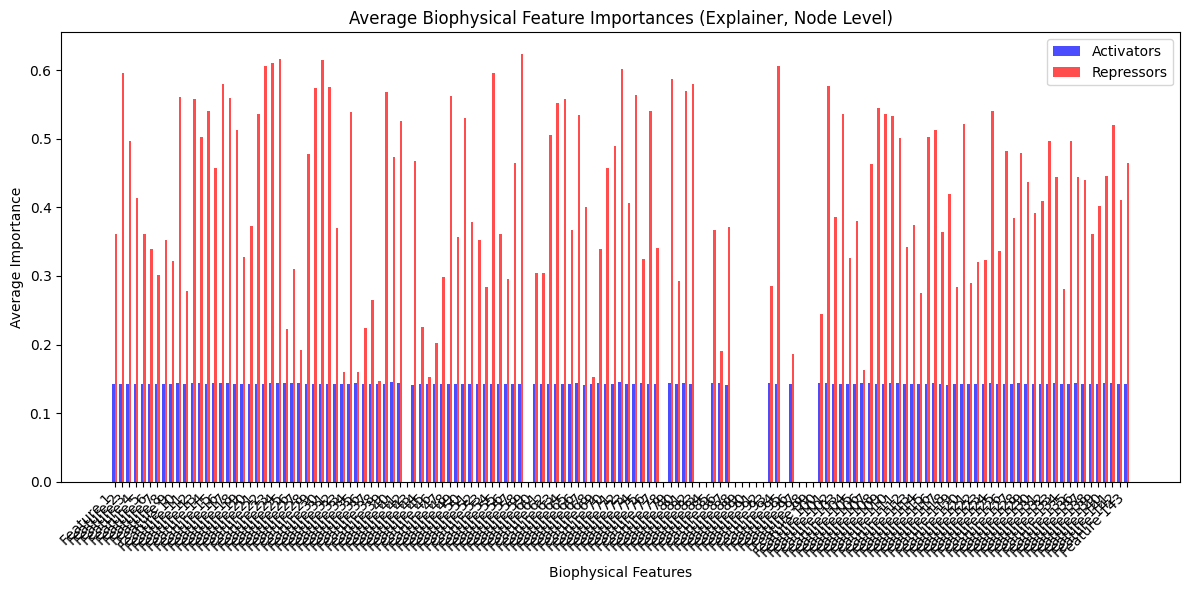

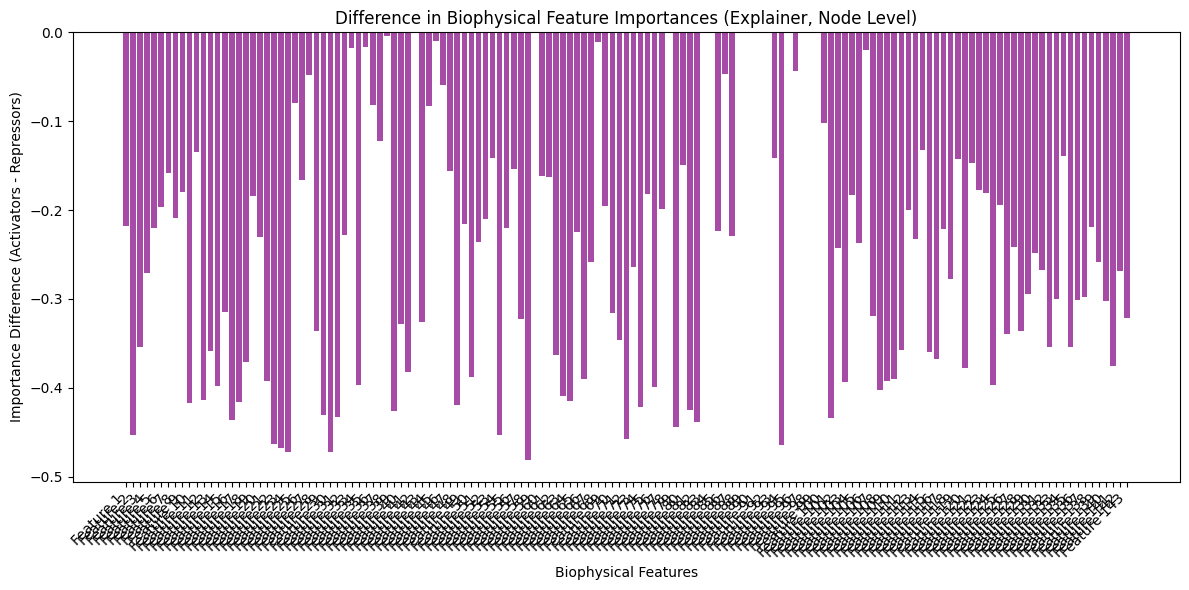

In [76]:
import matplotlib.pyplot as plt

# Get the number of biophysical features
num_features = len(avg_activator_node_importance)

# Define labels for biophysical features (adjust based on your dataset)
feature_labels = [f'Feature {i+1}' for i in range(num_features)]

# Plot average feature importances for activator and repressor nodes
fig, ax = plt.subplots(figsize=(12, 6))

# Bar width for the plot
bar_width = 0.35

# X positions for the bars
index = np.arange(num_features)

# Plot activator and repressor feature importances side by side
ax.bar(index, avg_activator_node_importance, bar_width, label='Activators', color='blue', alpha=0.7)
ax.bar(index + bar_width, avg_repressor_node_importance, bar_width, label='Repressors', color='red', alpha=0.7)

# Add labels and title
ax.set_xlabel('Biophysical Features')
ax.set_ylabel('Average Importance')
ax.set_title('Average Biophysical Feature Importances (Explainer, Node Level)')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(feature_labels, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

# Plot the difference in feature importances
plt.figure(figsize=(12, 6))
plt.bar(index, node_importance_diff, color='purple', alpha=0.7)
plt.xlabel('Biophysical Features')
plt.ylabel('Importance Difference (Activators - Repressors)')
plt.title('Difference in Biophysical Feature Importances (Explainer, Node Level)')
plt.xticks(index, feature_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [77]:
# Normalize each node's feature importance vector to sum to 1
activator_node_importances_normalized = [node_imp / node_imp.sum() for node_imp in activator_node_importances_flat]
repressor_node_importances_normalized = [node_imp / node_imp.sum() for node_imp in repressor_node_importances_flat]

# Convert to NumPy arrays
activator_node_importances_normalized = np.array(activator_node_importances_normalized)
repressor_node_importances_normalized = np.array(repressor_node_importances_normalized)

# Calculate average feature importances for activators and repressors
avg_activator_node_importance = activator_node_importances_normalized.mean(axis=0)
avg_repressor_node_importance = repressor_node_importances_normalized.mean(axis=0)

# Calculate the difference in average feature importances
node_importance_diff = avg_activator_node_importance - avg_repressor_node_importance


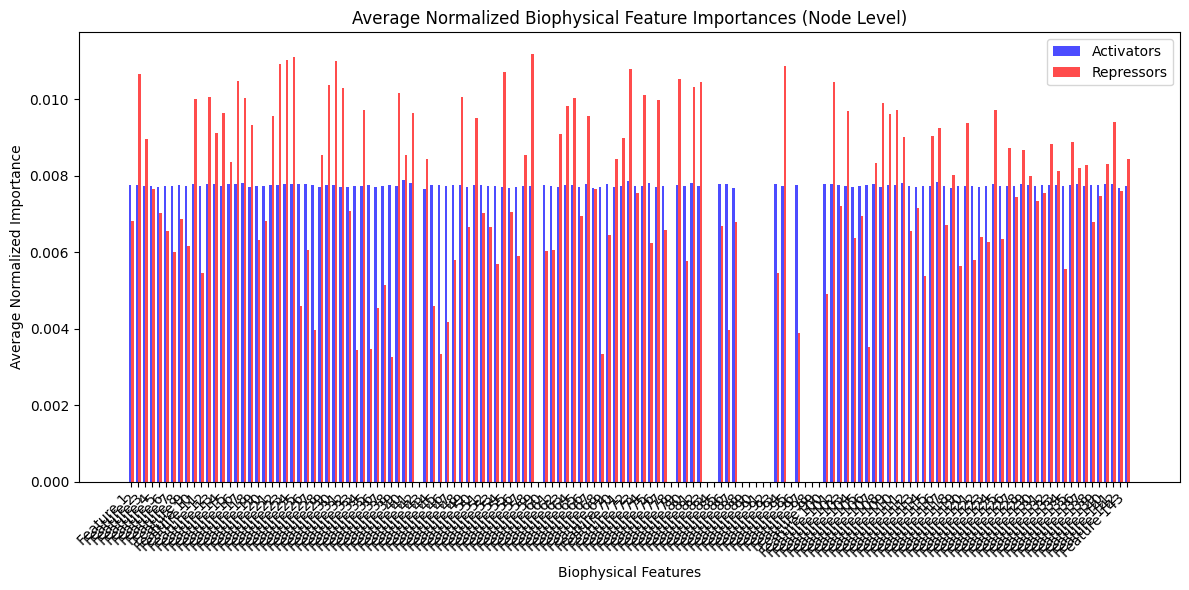

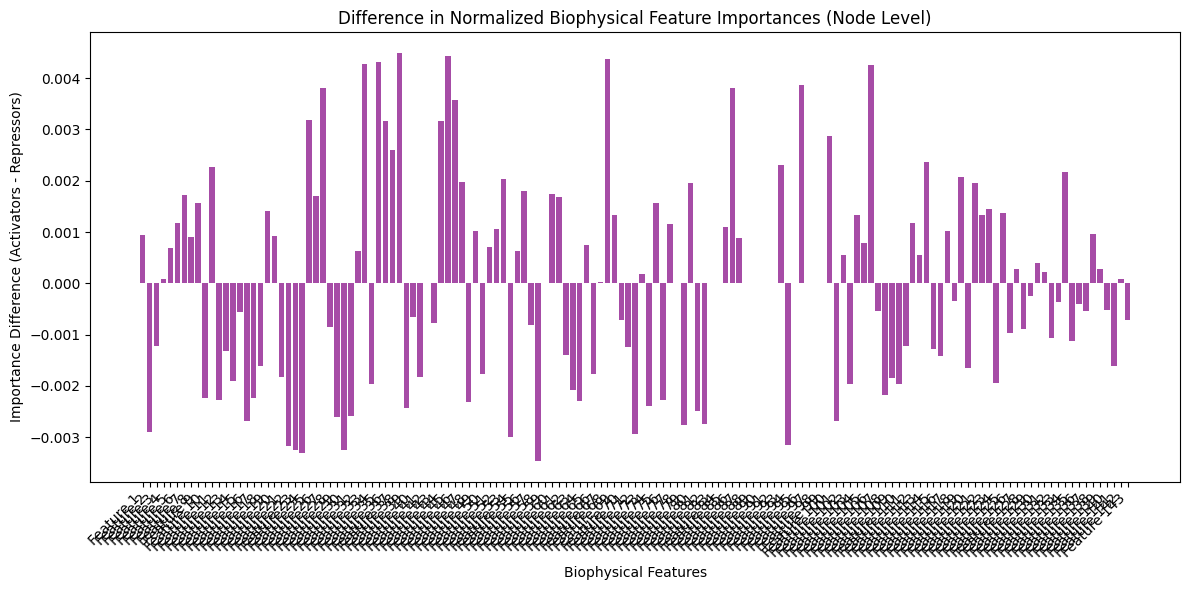

In [78]:
import matplotlib.pyplot as plt

# Get the number of biophysical features
num_features = len(avg_activator_node_importance)

# Define labels for biophysical features (adjust based on your dataset)
feature_labels = [f'Feature {i+1}' for i in range(num_features)]

# Plot average normalized feature importances for activator and repressor nodes
fig, ax = plt.subplots(figsize=(12, 6))

# Bar width for the plot
bar_width = 0.35

# X positions for the bars
index = np.arange(num_features)

# Plot activator and repressor feature importances side by side
ax.bar(index, avg_activator_node_importance, bar_width, label='Activators', color='blue', alpha=0.7)
ax.bar(index + bar_width, avg_repressor_node_importance, bar_width, label='Repressors', color='red', alpha=0.7)

# Add labels and title
ax.set_xlabel('Biophysical Features')
ax.set_ylabel('Average Normalized Importance')
ax.set_title('Average Normalized Biophysical Feature Importances (Node Level)')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(feature_labels, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

# Plot the difference in normalized feature importances
plt.figure(figsize=(12, 6))
plt.bar(index, node_importance_diff, color='purple', alpha=0.7)
plt.xlabel('Biophysical Features')
plt.ylabel('Importance Difference (Activators - Repressors)')
plt.title('Difference in Normalized Biophysical Feature Importances (Node Level)')
plt.xticks(index, feature_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [79]:
activator_node_importances

[tensor([[0.1436, 0.1335, 0.1466, 0.1549, 0.1430, 0.1238, 0.1527, 0.1515, 0.1518,
          0.1329, 0.1377, 0.1521, 0.1364, 0.1371, 0.1337, 0.1453, 0.1398, 0.1374,
          0.1395, 0.1459, 0.1473, 0.1498, 0.1448, 0.1478, 0.1405, 0.1433, 0.1488,
          0.1360, 0.1367, 0.1376, 0.1421, 0.1505, 0.1480, 0.1508, 0.1418, 0.1353,
          0.1409, 0.1394, 0.1254, 0.1514, 0.1339, 0.0000, 0.1242, 0.1402, 0.1476,
          0.1394, 0.1410, 0.1467, 0.1331, 0.1492, 0.1374, 0.1415, 0.1542, 0.1421,
          0.1336, 0.1379, 0.1617, 0.1469, 0.0000, 0.1452, 0.1401, 0.1422, 0.1236,
          0.1430, 0.1279, 0.1490, 0.1375, 0.1517, 0.1496, 0.1370, 0.1497, 0.1342,
          0.1272, 0.1460, 0.1505, 0.1333, 0.1642, 0.0000, 0.1320, 0.1305, 0.1690,
          0.1341, 0.0000, 0.0000, 0.1417, 0.1482, 0.1323, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.1516, 0.1523, 0.0000, 0.1522, 0.0000, 0.0000, 0.0000,
          0.1338, 0.1436, 0.1478, 0.1409, 0.1376, 0.1428, 0.1342, 0.1352, 0.1550,
          0.1158